In [111]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType

In [112]:
df = pd.read_csv("./low_confidence_samples/big_data.csv")
df

,Unnamed: 0,text,label,preprocess_text
0,7,"This show was an amazing, fresh & innovative i...",0,amazing fresh innovative idea 70 air 7 8 year ...
1,14,This a fantastic movie of three prisoners who ...,2,fantastic movie prisoner famous actor george c...
2,32,My first exposure to the Templarios & not a go...,0,exposure templarios good excited find title of...
3,43,"I had heard good things about ""States of Grace...",0,hear good thing states grace come open mind th...
4,53,I cannot believe I enjoyed this as much as I d...,2,believe enjoy anthology story well par link st...
...,...,...,...,...
25413,678916,Let me start by telling you what they got righ...,1,let start tell get right story good rely comic...
25414,678933,I was disappointed when our check in time was ...,1,disappoint check time 11:30am 12:30pm wait h...
25415,678949,Don't. Just don't. Every horrible thing people...,1,horrible thing people say 100 true read review...
25416,678981,This used be Cathy House. . Now The Jade. . It...,2,cathy house jade improvement dim sum way well ...


In [113]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True)

# Ensure text data is a list of strings and drop missing values
df_train['text'] = df_train['preprocess_text'].astype(str)
df_test['text'] = df_test['preprocess_text'].astype(str)

# Ensure text is lowercase
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

In [114]:
df_train

,Unnamed: 0,text,label,preprocess_text
13463,288325,"word \""premium\ place outdate think selectio...",1,"word \""premium\ place outdate think selectio..."
24623,648051,come breakfast 10 find customer good sign supe...,1,come breakfast 10 find customer good sign supe...
2184,27159,anybody movie comedy go finacee fall asleep as...,0,anybody movie comedy go finacee fall asleep as...
14371,316305,begrudge pei wei question star pei wei quest...,2,begrudge pei wei question star pei wei quest...
5945,72151,diy acid wash short can`t wait look like,1,diy acid wash short can`t wait look like
...,...,...,...,...
21575,545072,"4 star lovely \""traditional\ albeit veggie ver...",2,"4 star lovely \""traditional\ albeit veggie ver..."
5390,65671,ack weird tweet mention timeline oh wait...,0,ack weird tweet mention timeline oh wait...
860,11152,catch screening sundance film festival awe abs...,2,catch screening sundance film festival awe abs...
15795,361249,eh okay.\n\nlike club vegas entry line move sn...,1,eh okay.\n\nlike club vegas entry line move sn...


In [115]:
df_test

,Unnamed: 0,text,label,preprocess_text
20661,516768,place name america disappointment shop instead...,1,place name america disappointment shop instead...
5449,66328,stop twittering maryland cookie bgt,1,stop twittering maryland cookie bgt
21056,527970,great little cafe nestle bough charming polish...,2,great little cafe nestle bough charming polish...
9406,166502,complete waste time take 10 minute look round ...,1,complete waste time take 10 minute look round ...
1818,22626,taste film continue astound probably infuriate...,2,taste film continue astound probably infuriate...
...,...,...,...,...
16786,391324,far big f21 store go shopping trip find cute...,2,far big f21 store go shopping trip find cute...
8395,131890,probably say place today finally trip inside s...,2,probably say place today finally trip inside s...
3187,39189,watch film take acid read philip k. dick think...,2,watch film take acid read philip k. dick think...
11448,231570,place creepy,1,place creepy


In [ ]:
model_name = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [117]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])

# Adding short max length to lower training time
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17792 [00:00<?, ? examples/s]

Map:   0%|          | 0/7626 [00:00<?, ? examples/s]

In [118]:
import torch
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: cuda


In [119]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],  # BERT uses query, key, value in attention
    lora_dropout=0.1,
    bias="all",
    task_type=TaskType.SEQ_CLS
)

training_args = TrainingArguments(
    output_dir="./results/" + model_name,
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    #gradient_checkpointing=True,
    num_train_epochs=3,
    dataloader_num_workers=5,
    #logging_steps=100,
    weight_decay=0.01,
)

model = get_peft_model(model, lora_config)
model = model.to(device)

for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
# Define a compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {'accuracy': accuracy}

In [121]:
from transformers import TrainerCallback

class LossAccuracyLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append((state.epoch, logs["loss"]))
            if "eval_accuracy" in logs:
                self.eval_accuracy.append((state.epoch, logs["eval_accuracy"]))


In [122]:
logger_callback = LossAccuracyLogger()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [123]:
# Train the model
trainer.train()

Step,Training Loss
500,1.100700
1000,1.033500
1500,1.005800
2000,1.004800
2500,0.999200


KeyboardInterrupt: 

In [ ]:
trainer.save_model("./results/" + model_name + "v1")

{'eval_loss': 0.9946369528770447, 'eval_accuracy': 0.448334644636769, 'eval_runtime': 72.0795, 'eval_samples_per_second': 105.8, 'eval_steps_per_second': 6.618, 'epoch': 3.0}


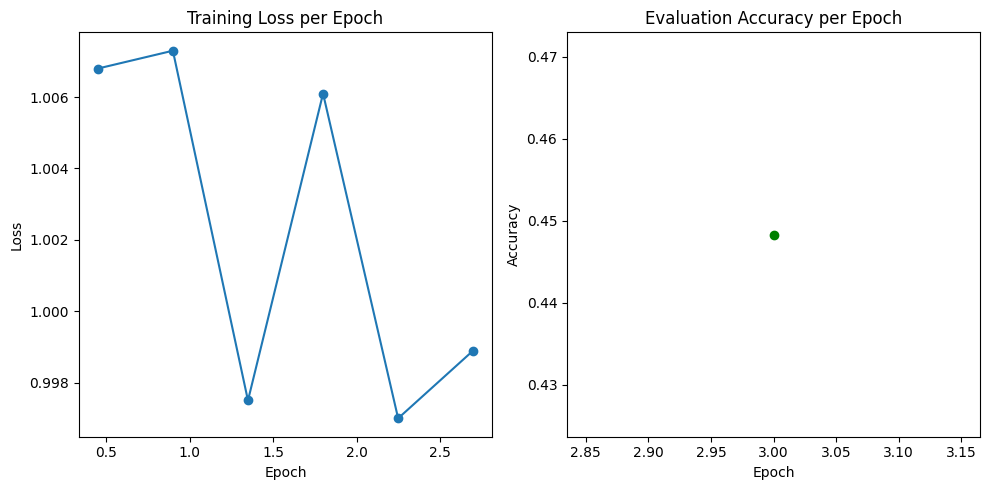

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

import matplotlib.pyplot as plt

# Unpack the epoch and values
train_epochs, train_losses = zip(*logger_callback.train_loss)
eval_epochs, eval_accuracies = zip(*logger_callback.eval_accuracy)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot eval accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracies, marker='o', color='green')
plt.title("Evaluation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [77]:
# Evaluate fine-tuned model on all samples, including non low confidence ones
df_test = pd.read_csv('./data/SA_cleaned.csv')
df_test['text'] = df_test['preprocess_text'].astype(str)
df_test['label'] = df_test['label'].astype(int)
df_test

,Unnamed: 0,text,label,preprocess_text
0,0,reviewer mention watch 1 oz episode hook right...,2,reviewer mention watch 1 oz episode hook right...
1,1,wonderful little production br /><br />the fil...,2,wonderful little production br /><br />the fil...
2,2,think wonderful way spend time hot summer week...,2,think wonderful way spend time hot summer week...
3,3,basically family little boy jake think zombie ...,0,basically family little boy jake think zombie ...
4,4,petter mattei love time money visually stunnin...,2,petter mattei love time money visually stunnin...
...,...,...,...,...
678506,679009,ryan good yelp claim courteous knowledgable he...,2,ryan good yelp claim courteous knowledgable he...
678507,679010,professional \nfriendly\non time affordable!\n...,2,professional \nfriendly\non time affordable!\n...
678508,679011,phone call voicemail message return stupid w...,1,phone call voicemail message return stupid w...
678509,679012,look like good review go head place jason ry...,1,look like good review go head place jason ry...


In [78]:
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback]
)

results_all = trainer.evaluate()
print(results_all)

Map:   0%|          | 0/678511 [00:00<?, ? examples/s]

KeyboardInterrupt: 